In [1]:
%matplotlib inline

# Reconstrucción de parte de una imagen en base a otra

En este cuaderno, vamos a entrenar un modelo de regresión lineal para que reconstruya la mitad de abajo de una imagen, utilizando como entrada la mitad de arriba. Como las imágenes son de 8x8, o sea 64 píxeles, la entrada serán entonces los 32 píxeles de arriba de la imagen, y la salida los 32 de abajo.

Vamos a comparar dos métodos de optimización. El primero es el clásico método analítico basado en [cuadrados mínimos](https://en.wikipedia.org/wiki/Linear_least_squares) que se utiliza muy comunmente en estadística y utilizando la implementación de la librería [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). El otro es el descenso de gradiente estocástico. 

En este caso, veremos que el descenso de gradiente es superior al método analítico, dada la gran cantidad de variables de entrada y salida que requiere el modelo. 

In [2]:
import rnutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm
from sklearn.datasets import load_digits
from tensorflow import keras

rnutil: Los archivos de los conjuntos de datos que ofrece este paquete también están disponibles en https://github.com/facundoq/redes-neuronales-util/tree/main/rnutil/data para descargar de forma individual
rnutil: Agregando el parámetro local=True en las funciones rnutil.load_dataset_numpy, rnutil.load_dataset_pandas y rnutil.load_image se puede cargar una versión local de un archivo en lugar de la versión que ofrece este paquete.


In [3]:
#Carga del dataset

digits = load_digits()
data=digits.images.reshape(-1,64)
images=digits.images
n,d=data.shape # n= cant ejemplos, d=tamaño de la imagen
dx=32 # pixeles de la parte de arriba
dy=d-dx # pixeles de la parte de abajo
# x tiene la parte de arriba de la imagen
x=data[:,0:dx]
# y tiene la parte de abajo de la imagen
y=data[:,dx:]

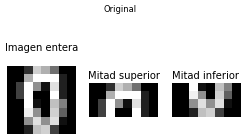

In [4]:
# Visualizamos ejemplos del dataset

def plot_sample(x,y,sample_index,title="Original"):
    upper=x[sample_index,:].reshape((4,8))
    lower=y[sample_index,:].reshape((4,8))
    complete=np.vstack([upper,lower])
    
    fig,(a1,a2,a3)=plt.subplots(1,3,dpi=50)
    plt.suptitle(title)
    #Visualizar una muestra
    a1.matshow(complete, cmap=cm.gray, vmin=0, vmax=16) 
    a1.set_title("Imagen entera")
    a1.axis("off")

    a2.imshow(upper, cmap=cm.gray, vmin=0, vmax=16)
    a2.set_title("Mitad superior")
    a2.axis("off")

    a3.imshow(lower, cmap=cm.gray, vmin=0, vmax=16)
    a3.set_title("Mitad inferior")
    a3.axis("off")
    plt.show()

## CAMBIAR INDICE DE IMAGEN A VISUALIZAR
sample_index=20
plot_sample(x,y,sample_index)

# Optimización de los parámetros mediante cuadrádos mínimos (método analítico)

Utilizando la librería `sklearn`, vamos a optimizar `w` y `b` utilizando un método analítico clásico. Este método no funciona bien para este problema por la gran cantidad de dimensiones del mismo y tiene un error sustancialmente peor que el modelo entrenado con descenso de graidente que veremos más abajo.

Modelo analítico entrenado, error=3036.654706010187


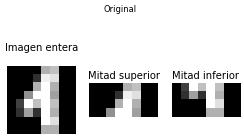

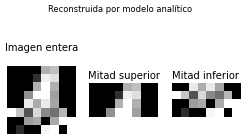

In [5]:
def analytic_model(x,y):
    from sklearn import  linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x,y)
    optimal_w=regr.coef_
    optimal_b=regr.intercept_
    y_pred_analytic=x.dot(optimal_w)+optimal_b
    optimal_error=((y_pred_analytic-y)**2).mean()
    
    return optimal_w,optimal_b,optimal_error,y_pred_analytic

# parámetros y error del modelo analítico
analytic_w,analytic_b,analytic_error,y_pred_analytic = analytic_model(x,y)
print(f"Modelo analítico entrenado, error={analytic_error}")

sample_index=200
plot_sample(x,y,sample_index)
plot_sample(x,y_pred_analytic,sample_index,title="Reconstruida por modelo analítico")


# Entrenamiento de un modelo Keras

Inicialización aleatoria del modelo; vuelve a correr esta celda para obtener otros resultados


2022-04-02 18:09:15.089511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 18:09:15.107039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 18:09:15.107146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 18:09:15.108005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Entrenando modelo con descenso de gradiente...


2022-04-02 18:09:15.999155: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


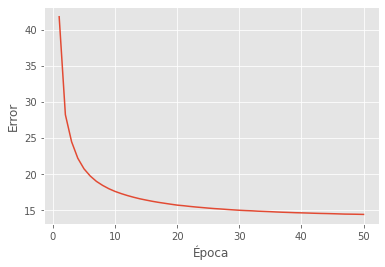

In [6]:
n,d_in=x.shape
n,d_out=y.shape

# Creación del modelo inicial
print("Inicialización aleatoria del modelo; vuelve a correr esta celda para obtener otros resultados")
# Creo un modelo lineal
model = keras.Sequential([
    keras.layers.Dense(d_out,input_shape=(d_in,), activation=None)])

sgd = keras.optimizers.SGD(learning_rate=0.001)
model.compile(
  optimizer=sgd,
  loss="mse",
  metrics=[], # metricas para ir calculando en cada iteracion o batch (ninguna ahora)
)
print(f"Entrenando modelo con descenso de gradiente...")
history=model.fit(x,y,batch_size=32,epochs=50,verbose=False)

rnutil.plot_loss(history.history["loss"])

# Visualización de la reconstrucción del modelo entrenado con descenso de gradiente

57/57 [==============================] - 0s 363us/step


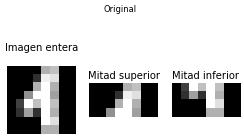

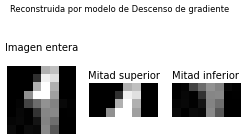

In [7]:
y_pred = model.predict(x)

sample_index=200
plot_sample(x,y,sample_index)
plot_sample(x,y_pred,sample_index,title="Reconstruida por modelo de Descenso de gradiente")